# Stellar Initial Mass Function (IMF)
We are going to use a Salpeter IMF to generate stellar IMF data and then use MCMC to guess the slope.

The Salpeter IMF is given by:
$\frac{dN}{dM} \propto \frac{M}{M_\odot}^{-\alpha} ~~ or ~~ \frac{dN}{dlogM} \propto \frac{M}{M_\odot}^{1-\alpha}$

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import corner
import emcee

%matplotlib inline

In [61]:
def sampleFromSalpeter(N,alpha,M_min,M_max):
    # Draw random samples from a Salpeter IMF.
    # N     ... number of samples.
    # alpha ... power-law index.
    # M_min ... lower bound of mass interval.
    # M_max ... upper bound of mass interval.
    # Convert limits from M to logM.
    log_M_Min = np.log(M_min)
    log_M_Max = np.log(M_max)
    # Since Salpeter SMF has a negative slope the maximum likelihood occurs at M_min
    maxlik = M_min**(1.0 - alpha)
    
    # Prepare array for output masses.
    Masses = []
    # Fill in array.
    while (len(Masses) < N):
        # Draw a candidate from logM interval.
        logM = np.random.uniform(log_M_Min,log_M_Max)
        M = np.exp(logM)
        # Compute likelihood of candidate from Salpeter SMF.
        likelihood = M**(1.0 - alpha)
        # Accept randomly.
        u = np.random.uniform(0.0,maxlik)
        if (u < likelihood):
            Masses.append(M)
    return Masses

# and now generate the data
N      = 1000000  # Draw 1 Million stellar masses.
alpha  = 2.35
M_min  = 1.0
M_max  = 100.0
log_M_min  = np.log10(M_min)
log_M_max  = np.log10(M_max)
Masses = sampleFromSalpeter(N, alpha, M_min, M_max)
LogM   = np.log(np.array(Masses))
D      = np.mean(LogM)*N

Here we have created a set of test stellar mass data, distributed according to the Salpeter IMF, and now we will perform a MCMC to guess the slope.  

We are given then a set of N-stellar masses, with negligible errors in the measurements.
Assuming that the minimum and maximum masses are known, the likelihood of the problem is: 

$\mathcal L(\{M_1,M_2,\ldots,M_N\};\alpha) = \prod_{n=1}^N p(M_n|\alpha) = \prod_{n=1}^N c\left(\frac{M_n}{M_\odot}\right)^{-\alpha}$

where the normalization constant c can be found by:

$\int_{M_{min}}^{M_{max}}c M^{-\alpha} dM = 1 \Rightarrow c\frac{M_{max}^{1-\alpha}-M_{min}^{1-\alpha}}{1-\alpha}=1$

### 1) EMCEE MCMC

In [62]:
def ln_likelihood(params, D, N, M_min, M_max):
    # Define logarithmic likelihood function.
    # params ... array of fit params, here just alpha
    # D      ... sum over log(M_n)
    # N      ... number of data points.
    # M_min  ... lower limit of mass interval
    # M_max  ... upper limit of mass interval
    alpha = params[0]  # extract alpha
    # Compute normalisation constant.
    c = (1.0 - alpha)/(M_max**(1.0-alpha)
                        - M_min**(1.0-alpha))
    # return log likelihood.
    return N*np.log(c) - alpha*D

def ln_prior(params):
    return 0.0

def ln_posterior(params, D, N, M_min, M_max):
    lp = ln_prior(params)
    ll = ln_likelihood(params, D, N, M_min, M_max)
    return lp+ll

In [63]:
# Running the MCMC
nwalkers, ndim = 100, 50

# The array of initial guess
initial = np.array([3.0])
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(D, N, M_min, M_max))
pos, prob, state = sampler.run_mcmc(p0, 1000)

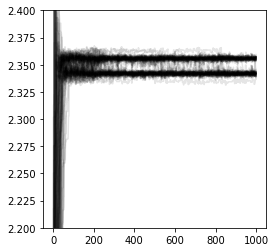

('The alpha is', 2.3569855770750161)


In [64]:
# Plot the trace
fig, ax = plt.subplots(1,1, figsize=(4,4))

# Plot trace
for j in range(nwalkers):
    ax.plot(sampler.chain[j,:,0], alpha=0.1, color='k')
plt.ylim(2.2,2.4)
plt.show()

print('The alpha is',pos[0,0])

In [43]:
# # Reset the sampler, restart the sampler at this current position, 
# # which we saved from before and called "pos"
# sampler.reset()
# pos,prob,state = sampler.run_mcmc(pos,1000)
# corner.corner(sampler.flatchain)

# plt.show()

### 2) We will give an example using the Metropolis-Hastings MCMC.

In [44]:
# initial guess for alpha as a list.
guess = [3.0]
# Prepare storing MCMC chain as list of lists.
A = [guess]
# define stepsize of MCMC.
stepsizes = [0.0005]  # list of stepsizes
accepted  = 0.0

# Metropolis-Hastings with 10,000 iterations.
for n in range(10000):
    old_alpha  = A[len(A)-1]  # old parameter value as array
    old_loglik = ln_likelihood(old_alpha, D, N, M_min,M_max)
    # Suggest new candidate from Gaussian proposal distribution.
    new_alpha = np.zeros([len(old_alpha)])
    for i in range(len(old_alpha)):
        # Use stepsize provided for every dimension.
        new_alpha[i] = np.random.normal(old_alpha[i], stepsizes[i])
    new_loglik = ln_likelihood(new_alpha, D, N, M_min,M_max)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A.append(new_alpha)
        accepted = accepted + 1.0  # monitor acceptance
    else:
        u = np.random.uniform(0.0,1.0)
        if (u < np.exp(new_loglik - old_loglik)):
            A.append(new_alpha)
            accepted = accepted + 1.0  # monitor acceptance
        else:
            A.append(old_alpha)

print("Acceptance rate = "+str(accepted/10000.0))

Acceptance rate = 0.7625


In [45]:
# Discard first half of MCMC chain and thin out the rest.
Clean = []
for n in range(5000,10000):
    if (n % 10 == 0):
        Clean.append(A[n][0])

In [46]:
# Print Monte-Carlo estimate of alpha.
print("Mean:  "+str(np.mean(Clean)))
print("Sigma: "+str(np.std(Clean)))

Mean:  2.3494898514
Sigma: 0.00132986120388


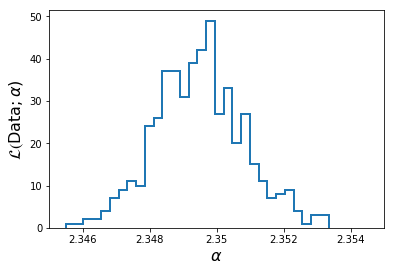

In [47]:
plt.figure(1)
plt.hist(Clean, 30, histtype='step', lw=2)
plt.xticks([2.346,2.348,2.35,2.352,2.354],
           [2.346,2.348,2.35,2.352,2.354])
plt.xlim(2.345,2.355)
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=16)
plt.show()

### 3) We will now perform the same procedure with Hamiltonian dynamics

In [51]:
def evaluateGradient(params, D, N, M_min, M_max, logMmin, logMmax):
    alpha = params[0]  # extract alpha
    grad = logMmin*M_min**(1.0-alpha) - logMmax*M_max**(1.0-alpha)
    grad = 1.0 + grad*(1.0 - alpha)/(M_max**(1.0-alpha)
            - M_min**(1.0-alpha))
    grad = -D - N*grad/(1.0 - alpha)
    return np.array(grad)

In [54]:
guess = [3.0]
A = [guess]
# define stepsize of HMC.
stepsize = 0.00004
accepted  = 0.0

# Hamiltonian Monte-Carlo.
for n in range(50000):
    old_alpha  = A[len(A)-1]
    # Remember, energy = -loglik
    old_energy = - ln_likelihood(old_alpha, D, N, M_min, M_max)
    old_grad   = - evaluateGradient(old_alpha, D, N, M_min, M_max, log_M_min, log_M_max)

    new_alpha = copy.copy(old_alpha)  # deep copy of array
    new_grad  = copy.copy(old_grad)   # deep copy of array
    # Suggest new candidate using gradient + Hamiltonian dynamics.
    # draw random momentum vector from unit Gaussian.
    p = np.random.normal(0.0, 1.0)
    H = np.dot(p,p)/2.0 + old_energy    # compute Hamiltonian

    # Do 5 Leapfrog steps.
    for tau in range(5):
        # make half step in p
        p         = p - stepsize*new_grad/2.0
        # make full step in alpha
        new_alpha = new_alpha + stepsize*p
        # compute new gradient
        new_grad  = - evaluateGradient(old_alpha, D, N, M_min,
                         M_max, log_M_min, log_M_max)
        # make half step in p
        p         = p - stepsize*new_grad/2.0

    # Compute new Hamiltonian. Remember, energy = -loglik.
    new_energy = - ln_likelihood(new_alpha, D, N, M_min,
                     M_max)
    new_grad  = - evaluateGradient(old_alpha,D, N, M_min,
                         M_max, log_M_min, log_M_max)
    newH       = np.dot(p,p)/2.0 + new_energy
    dH         = newH - H

    # Accept new candidate in Monte-Carlo fashion.
    if (dH < 0.0):
        A.append(new_alpha)
        accepted = accepted + 1.0
    else:
        u = np.random.uniform(0.0,1.0)
        if (u < np.exp(-dH)):
            A.append(new_alpha)
            accepted = accepted + 1.0
        else:
            A.append(old_alpha)

print("Acceptance rate = "+str(accepted/float(len(A))))

Acceptance rate = 0.602507949841


In [55]:
# Discard first half of MCMC chain and thin out the rest.
Clean = []
for n in range(len(A)//2,len(A)):
    if (n % 10 == 0):
        Clean.append(A[n][0])
        
# Print Monte-Carlo estimate of alpha.
print("Mean:  "+str(np.mean(Clean)))
print("Sigma: "+str(np.std(Clean)))

Mean:  2.34944128996
Sigma: 0.00146921517324


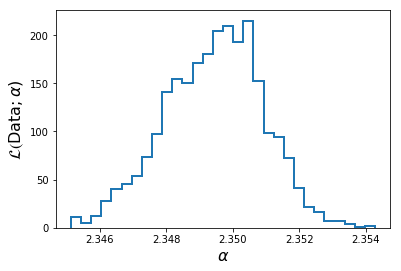

In [59]:
plt.figure(1)
plt.hist(Clean, 30, histtype='step', lw=2)
#plt.xlim(2.3,2.358)
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\cal L($Data$;\alpha)$', fontsize=16)
plt.show()